## Package Installation

In [ ]:
%pip install -r requirements.txt

In [1]:
from models.sam import SamPredictor, sam_model_registry
from models.sam.modeling.prompt_encoder import attention_fusion
import numpy as np
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from dsc import dice_coeff
import torchio as tio
import nrrd
import PIL
import cfg
from funcs import *
from predict_funs import *
args = cfg.parse_args()
from monai.networks.nets import VNet
args.if_mask_decoder_adapter=True
args.if_encoder_adapter = True
args.decoder_adapt_depth = 2
%matplotlib inline

c:\Users\DUDU\Documents\GitHub\SegmentAnyBone\models\sam\modeling\tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_5m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\DUDU\Documents\GitHub\SegmentAnyBone\models\sam\modeling\tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_11m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\DUDU\Documents\GitHub\SegmentAnyBone\models\sam\modeling\tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_21m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.


## Load models

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
checkpoint_directory = './' # path to your checkpoint
img_folder = os.path.join('images')
gt_msk_folder = os.path.join('masks')
predicted_msk_folder = os.path.join('predicted_masks')
cls = 1

sam_fine_tune = sam_model_registry["vit_t"](args,checkpoint=os.path.join('mobile_sam.pt'),num_classes=2)
sam_fine_tune.attention_fusion = attention_fusion()  
sam_fine_tune.load_state_dict(torch.load(os.path.join(checkpoint_directory,'bone_sam.pth'),map_location=torch.device(device)), strict = True)
sam_fine_tune = sam_fine_tune.to(device).eval()

vnet = VNet().to(device)
model_directory = "./"
vnet.load_state_dict(torch.load(os.path.join(model_directory,'atten.pth'),map_location=torch.device(device)))

cpu


<All keys matched successfully>

## 2D Slice Prediction & Evaluation

In [6]:
def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    voxels, header = nrrd.read(os.path.join(gt_msk_folder,mask_name))
    mask_gt = voxels

    msk = Image.fromarray(mask_gt[:,:,slice_id].astype(np.uint8), 'L')
    msk = transforms.Resize((256,256))(msk)
    msk_gt = (transforms.ToTensor()(msk)>0).float()

    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt

def predictSlice(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled):
    
    image1_vol = tio.ScalarImage(os.path.join(img_folder, image_name))
    print('vol shape: %s vol spacing %s' %(image1_vol.shape,image1_vol.spacing))

    image_tensor = image1_vol.data
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)

    # Clip the data
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)

    # Normalize the data to [0, 1] 
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)

    image1_vol.set_data(image_tensor)
    atten_map= pred_attention(image1_vol,vnet,slice_id,device)
    
    atten_map = torch.unsqueeze(torch.tensor(atten_map),0).float().to(device)
    print(atten_map.device)
    if attention_enabled:
        ori_img,pred_1,voxel_spacing1,Pil_img1,slice_id1 = evaluate_1_volume_withattention(image1_vol,sam_fine_tune,device,slice_id=slice_id,atten_map=atten_map)
    else:
        ori_img,pred_1,voxel_spacing1,Pil_img1,slice_id1 = evaluate_1_volume_withattention(image1_vol,sam_fine_tune,device,slice_id=slice_id)
        
    mask_pred = ((pred_1>0)==cls).float().cpu()

    return ori_img, mask_pred, atten_map

def visualizeSlicePrediction(ori_img, image_name, atten_map, msk_gt, mask_pred, dsc_gt):
    image = np.rot90(torchvision.transforms.Resize((args.out_size,args.out_size))(ori_img)[0])
    image_3d = np.repeat(np.array(image*255,dtype=np.uint8).copy()[:, :, np.newaxis], 3, axis=2)

    pred_mask_auto = (mask_pred[0])*255
    mask = (msk_gt.cpu()[0]>0)*255

    target_prediction =  [103,169,237]   
    image_pred_auto = drawContour(image_3d.copy(), np.rot90(pred_mask_auto),target_prediction,size=-1,a=0.6)

    target_prediction =  [100,255,106] 
    image_mask = drawContour(image_3d.copy(),np.rot90(mask),target_prediction,size=-1,a=0.6)

    fig, a = plt.subplots(1,4, figsize=(20,15))
    a[0].imshow(image,cmap='gray',vmin=0, vmax=1)
    a[0].set_title(image_name)
    a[0].axis(False)

    a[1].imshow(image_mask,cmap='gray',vmin=0, vmax=255)
    a[1].set_title('gt_mask',fontsize=10)
    a[1].axis(False)

    a[2].imshow(image_pred_auto,cmap='gray',vmin=0, vmax=255)
    a[2].set_title('pre_mask_auto, dsc %.2f'%(dsc_gt),fontsize=10)
    a[2].axis(False)

    a[3].imshow(np.rot90(atten_map.cpu()[0]),vmin=0, vmax=1,cmap='coolwarm')
    a[3].set_title('atten_map',fontsize=10)
    a[3].axis(False)

    plt.tight_layout()

In [ ]:
ori_img, predictedSliceMask, atten_map = predictSlice(
    image_name = '2.nii.gz', 
    lower_percentile = 1,
    upper_percentile = 99,
    slice_id = 50, # slice number
    attention_enabled = True, # if you want to use the depth attention
)

msk_gt, dsc_gt = evaluateSlicePrediction(
    mask_pred = predictedSliceMask, 
    mask_name = '2.nrrd', 
    slice_id = 50
)

visualizeSlicePrediction(
    ori_img=ori_img, 
    image_name='2.nii.gz', 
    atten_map=atten_map, 
    msk_gt=msk_gt, 
    mask_pred=predictedSliceMask, 
    dsc_gt=dsc_gt
)

dsc_gt: 0.5082728862762451


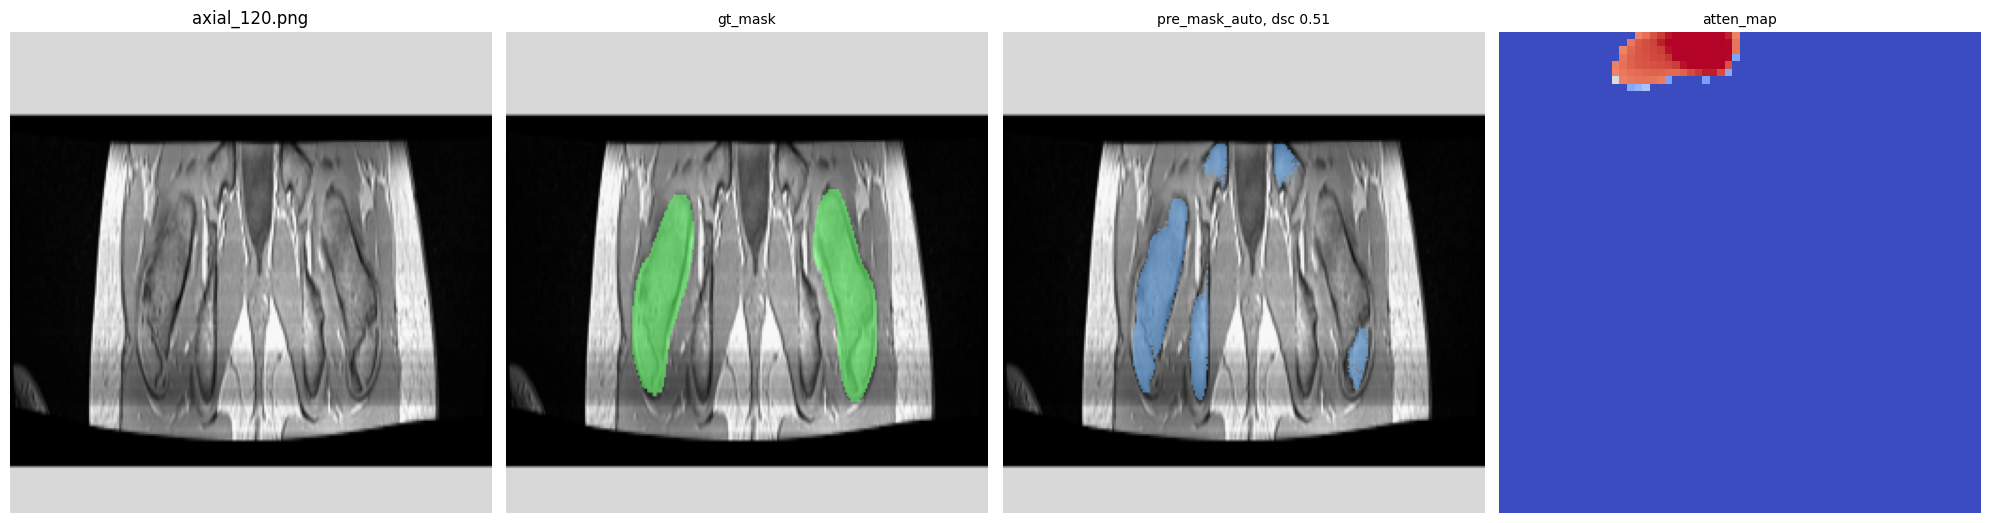

In [14]:
def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    # Read corresponding PNG mask
    msk = Image.open(os.path.join(gt_msk_folder, f"{mask_name}_{slice_id}.png"))  # Assume mask filename format is "name_sliceid.png"
    msk = transforms.Resize((256,256))(msk)
    # Convert RGB image to grayscale if needed
    if msk.mode != 'L':
        msk = msk.convert('L')
    msk_gt = (transforms.ToTensor()(msk)>0).float()
    
    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt

def predictSlice(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled):
    # Read PNG image
    img_path = os.path.join(img_folder, f"{image_name}_{slice_id}.png")
    image = Image.open(img_path)
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert to tensor and adjust dimensions
    image_tensor = transforms.ToTensor()(image)  # [1, H, W]
    
    # Adjust dimensions to [1, 1, H, W, 1] (channels, x, y, z)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension [1, 1, H, W]
    image_tensor = image_tensor.unsqueeze(-1)  # Add z dimension [1, 1, H, W, 1]
    
    # Data normalization
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    
    # Rearrange dimensions to (1, x, y, z)
    image_tensor = image_tensor.squeeze(0)  # Remove batch dimension
    
    # Create torchio ScalarImage object
    image1_vol = tio.ScalarImage(tensor=image_tensor)
    
    atten_map = pred_attention(image1_vol, vnet, 0, device)  # slice_id set to 0 as we only have one slice
    atten_map = torch.unsqueeze(torch.tensor(atten_map), 0).float().to(device)
    
    if attention_enabled:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0, atten_map=atten_map)
    else:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0)
    
    mask_pred = ((pred_1>0)==cls).float().cpu()
    return ori_img, mask_pred, atten_map

def visualizeSlicePrediction(ori_img, image_name, atten_map, msk_gt, mask_pred, dsc_gt):
    # Resize without rotation
    image = torchvision.transforms.Resize((args.out_size,args.out_size))(ori_img)[0]
    image_3d = np.repeat(np.array(image*255,dtype=np.uint8).copy()[:, :, np.newaxis], 3, axis=2)
    
    # Process mask without rotation
    pred_mask_auto = (mask_pred[0])*255
    mask = (msk_gt.cpu()[0]>0)*255
    
    # Draw contours without rotation
    target_prediction = [103,169,237]
    image_pred_auto = drawContour(image_3d.copy(), pred_mask_auto, target_prediction, size=-1, a=0.6)
    
    target_prediction = [100,255,106]
    image_mask = drawContour(image_3d.copy(), mask, target_prediction, size=-1, a=0.6)
    
    # Display images
    fig, a = plt.subplots(1,4, figsize=(20,15))
    a[0].imshow(image, cmap='gray', vmin=0, vmax=1)
    a[0].set_title(image_name)
    a[0].axis(False)
    
    a[1].imshow(image_mask, cmap='gray', vmin=0, vmax=255)
    a[1].set_title('gt_mask', fontsize=10)
    a[1].axis(False)
    
    a[2].imshow(image_pred_auto, cmap='gray', vmin=0, vmax=255)
    a[2].set_title('pre_mask_auto, dsc %.2f'%(dsc_gt), fontsize=10)
    a[2].axis(False)
    
    # Display attention map without rotation
    a[3].imshow(atten_map.cpu()[0], vmin=0, vmax=1, cmap='coolwarm')
    a[3].set_title('atten_map', fontsize=10)
    a[3].axis(False)
    
    plt.tight_layout()

# Usage example
ori_img, predictedSliceMask, atten_map = predictSlice(
    image_name = 'axial',  # Base image name, without slice_id
    lower_percentile = 1,
    upper_percentile = 99,
    slice_id = 120,  # Slice number
    attention_enabled = True
)

msk_gt, dsc_gt = evaluateSlicePrediction(
    mask_pred = predictedSliceMask,
    mask_name = 'axial',  # Base mask name, without slice_id
    slice_id = 120
)

# visualizeSlicePrediction function remains unchanged
visualizeSlicePrediction(
    ori_img=ori_img,
    image_name='axial_120.png',
    atten_map=atten_map,
    msk_gt=msk_gt,
    mask_pred=predictedSliceMask,
    dsc_gt=dsc_gt
)

## 3D Volume Prediction & Evaluation

In [77]:
def predictVolume(image_name, lower_percentile, upper_percentile):
    dsc_gt = 0
    image1_vol = tio.ScalarImage(os.path.join(img_folder,image_name))
    print('vol shape: %s vol spacing %s' %(image1_vol.shape,image1_vol.spacing))

    # Define the percentiles
    image_tensor = image1_vol.data
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)

    # Clip the data
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    # Normalize the data to [0, 1] 
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    image1_vol.set_data(image_tensor)
    
    mask_vol_numpy = np.zeros(image1_vol.shape)
    id_list = list(range(image1_vol.shape[3]))
    for id in id_list:
        atten_map = pred_attention(image1_vol,vnet,id,device)
        atten_map = torch.unsqueeze(torch.tensor(atten_map),0).float().to(device)
        
        ori_img,pred_1,voxel_spacing1,Pil_img1,slice_id1 = evaluate_1_volume_withattention(image1_vol,sam_fine_tune,device,slice_id=id,atten_map=atten_map)
        img1_size = Pil_img1.size
        mask_pred = ((pred_1>0)==cls).float().cpu()
        pil_mask1 = Image.fromarray(np.array(mask_pred[0],dtype=np.uint8),'L').resize(img1_size,resample= PIL.Image.NEAREST)
        mask_vol_numpy[0,:,:,id] = np.asarray(pil_mask1)
    
    mask_vol = tio.LabelMap(tensor=torch.tensor(mask_vol_numpy,dtype=torch.int), affine=image1_vol.affine)
    mask_save_folder = os.path.join(predicted_msk_folder,'/'.join(image_name.split('/')[:-1]))
    Path(mask_save_folder).mkdir(parents=True, exist_ok = True)
    mask_vol.save(os.path.join(mask_save_folder,image_name.split('/')[-1].replace('.nii.gz','_predicted_SAMatten_paired.nrrd')))
    return mask_vol

In [78]:
def predictAndEvaluateVolume(image_name, mask_name, lower_percentile, upper_percentile):
    dsc_gt = 0
    image1_vol = tio.ScalarImage(os.path.join(img_folder,image_name))
    print('vol shape: %s vol spacing %s' %(image1_vol.shape,image1_vol.spacing))

    # Define the percentiles
    image_tensor = image1_vol.data
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)

    # Clip the data
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    # Normalize the data to [0, 1] 
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    image1_vol.set_data(image_tensor)
    
    voxels, header = nrrd.read(os.path.join(gt_msk_folder,mask_name))
    mask_gt = voxels
    mask_vol_numpy = np.zeros(image1_vol.shape)
    id_list = list(range(image1_vol.shape[3]))
    for id in id_list:
        atten_map = pred_attention(image1_vol,vnet,id,device)
        atten_map = torch.unsqueeze(torch.tensor(atten_map),0).float().to(device)
        
        ori_img,pred_1,voxel_spacing1,Pil_img1,slice_id1 = evaluate_1_volume_withattention(image1_vol,sam_fine_tune,device,slice_id=id,atten_map=atten_map)
        img1_size = Pil_img1.size

        mask_pred = ((pred_1>0)==cls).float().cpu()
        msk = Image.fromarray(mask_gt[:,:,id].astype(np.uint8), 'L')
        msk = transforms.Resize((256,256))(msk)
        msk_gt = (transforms.ToTensor()(msk)>0).float().cpu()
        dsc_gt += dice_coeff(mask_pred.cpu(),msk_gt).item()
        pil_mask1 = Image.fromarray(np.array(mask_pred[0],dtype=np.uint8),'L').resize(img1_size,resample= PIL.Image.NEAREST)
        mask_vol_numpy[0,:,:,id] = np.asarray(pil_mask1)
    
    mask_vol = tio.LabelMap(tensor=torch.tensor(mask_vol_numpy,dtype=torch.int), affine=image1_vol.affine)
    mask_save_folder = os.path.join(predicted_msk_folder,'/'.join(image_name.split('/')[:-1]))
    Path(mask_save_folder).mkdir(parents=True,exist_ok = True)
    mask_vol.save(os.path.join(mask_save_folder,image_name.split('/')[-1].replace('.nii.gz','_predicted_SAMatten_paired.nrrd')))
    dsc_gt /= len(id_list)
    gt_vol = tio.LabelMap(tensor=torch.unsqueeze(torch.Tensor(mask_gt>0),0), affine=image1_vol.affine)
    dsc_vol = dice_coeff(mask_vol.data.float().cpu(),gt_vol.data).item()
    print('volume %s: slice_wise_dsc %.2f; vol_wise_dsc %.2f'%(image_name,dsc_gt,dsc_vol))

In [ ]:
mask = predictVolume(
    image_name = '2.nii.gz', 
    lower_percentile = 1, 
    upper_percentile = 99
)

In [ ]:
predictAndEvaluateVolume(
    image_name = '2.nii.gz', 
    mask_name = '2.nrrd',
    lower_percentile = 1, 
    upper_percentile = 99
)